# Example 2: diamond, ab initio tight-binding models

In [1]:
# You need to set the path to the programs.
path_to_semiinf = '/group2/jmlim/program/semiinf'
path_to_qe = '/group2/jmlim/program/qe-dev/bin'
path_to_w90 = '/group2/jmlim/program/wannier90'

In [2]:
# Import modules used
import sys
import subprocess
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
sys.path.insert(1, path_to_semiinf + '/util')
from wannier_tb import TBdict

In [3]:
# make custom colormap
cdict_wr = {'red':    ((0.0,  1.0, 1.0),
                       (1.0,  1.0, 1.0)),
             'green': ((0.0,  1.0, 1.0),
                       (1.0,  0.0, 0.0)),
             'blue':  ((0.0,  1.0, 1.0),
                       (1.0,  0.0, 0.0))}
cdict_br = {'red':    ((0.0,  1.0, 1.0),
                       (1.0,  0.0, 0.0)),
             'green': ((0.0,  1.0, 1.0),
                       (1.0,  0.0, 0.0)),
             'blue':  ((0.0,  1.0, 1.0),
                       (1.0,  1.0, 1.0))}
cmap_white_red = LinearSegmentedColormap('white_red', cdict_wr)
cmap_white_blue = LinearSegmentedColormap('white_blue', cdict_br)

In this example, we construct tight-binding models using Wannier functions as the basis functions. To construct the Wannier functions, we perform the following first-principles calculations.

In [4]:
# Bulk scf calculation
bashCommand = f'srun -n 16 {path_to_qe}/pw.x -nk 16 < bulk/diam.bulk.scf.in > bulk/diam.bulk.scf.out'
subprocess.call(bashCommand, shell=True)

# Bulk nscf calculation
bashCommand = f'srun -n 16 {path_to_qe}/pw.x -nk 16 < bulk/diam.bulk.nscf.in > bulk/diam.bulk.nscf.out'
subprocess.call(bashCommand, shell=True)

# Bulk wannier90 -pp run
bashCommand = f'{path_to_w90}/wannier90.x -pp bulk/diam.bulk'
subprocess.call(bashCommand, shell=True)

# Bulk pw2wan calculation
bashCommand = f'srun -n 16 {path_to_qe}/pw2wannier90.x < bulk/diam.bulk.pw2wan.in > bulk/diam.bulk.pw2wan.out'
subprocess.call(bashCommand, shell=True)

# Bulk wannier90 calculation
bashCommand = f'srun -n 16 {path_to_w90}/wannier90.x bulk/diam.bulk'
subprocess.call(bashCommand, shell=True)

0

In [5]:
# Slab DFT calculations can take a few minutes.

# Slab scf calculation
bashCommand = f'srun -n 32 {path_to_qe}/pw.x -nk 8 < slab/diam.slab.scf.in > slab/diam.slab.scf.out'
subprocess.call(bashCommand, shell=True)

# Slab nscf calculation
bashCommand = f'srun -n 32 {path_to_qe}/pw.x -nk 16 < slab/diam.slab.nscf.in > slab/diam.slab.nscf.out'
subprocess.call(bashCommand, shell=True)

# Slab wannier90 -pp run
bashCommand = f'{path_to_w90}/wannier90.x -pp slab/diam.slab'
subprocess.call(bashCommand, shell=True)

# Slab pw2wan calculation
bashCommand = f'srun -n 32 {path_to_qe}/pw2wannier90.x < slab/diam.slab.pw2wan.in > slab/diam.slab.pw2wan.out'
subprocess.call(bashCommand, shell=True)

# Slab wannier90 calculation
# Since the number of k points is 25, the maximum number of cores that can be used is 25.
bashCommand = f'srun -n 25 {path_to_w90}/wannier90.x slab/diam.slab'
subprocess.call(bashCommand, shell=True)

0

Remember to clean the temporary directory (where the wavefunction information is stored) to save storage. The wavefunctions are not used again after the pw2wan calculation.

In [6]:
bashCommand = f'rm -f temp/diam.*.save/wfc*.dat; rm -f temp/diam.bulk.wfc*; rm -f temp/diam.slab.wfc*'
subprocess.call(bashCommand, shell=True)

0

First, we set the k-point path along the X-Gamma-M line.

In [7]:
# k-point path along the M-Gamma-K line
# M = (0.0, 0.5)
# Gamma = (0.0, 0.0)
# M = (2/3, -1/3)
nkdiv1 = 100
nkdiv2 = nkdiv1
kxlist = np.concatenate((np.linspace(0.0, 0.0, nkdiv1, True)[:-1], np.linspace(0.0, 2./3., nkdiv2, True)))
kylist = np.concatenate((np.linspace(0.5, 0.0, nkdiv1, True)[:-1], np.linspace(0.0, -1./3., nkdiv2, True)))
kvecs = np.vstack((kxlist, kylist))
nk = kvecs.shape[1]
with open('kpath.dat', 'w') as f:
    f.write(f"{nk:8d}\n")
    for ik in range(nk):
        f.write(f"{kvecs[0,ik]:20.15f} {kvecs[1,ik]:20.15f}\n")

Now, we define the hopping parameters for the tight-binding model.

In [8]:
# Copy _hr.dat files from bulk, slab folder to here.
bashCommand = 'cp bulk/diam.bulk_hr.dat .'
subprocess.call(bashCommand, shell=True)
bashCommand = 'cp slab/diam.slab_hr.dat .'
subprocess.call(bashCommand, shell=True)

# Construct bulk and slab tight-binding models for s orbitals on a cubic lattice
seedname = 'diam'

Now, we are ready to run the semiinf.x program.

In [9]:
# Remove previous output files
bashCommand = 'rm -f *.out'
subprocess.call(bashCommand, stdout=subprocess.PIPE, shell=True)

# Run semiinf.x
bashCommand = f'srun -n 48 {path_to_semiinf}/semiinf.x semiinf.in > semiinf.out'
subprocess.call(bashCommand, stdout=subprocess.PIPE, shell=True)

0

From now on, we plot the calculate DOS, together with the bulk band structures which can be calculated by direct diagonalization. This is done by the `get_bands()` function of the `TBdict` class.

In DFT calculations, different systems can have different reference zero for energy. Thus, to stitch bulk and slab tight-binding models, one needs to match their energy references.
In the `semiinf.x` program, the energy reference is matched by subtracting `bulk_shift` from the diagonal matrix elements of the slab onsite energy. `bulk_shift` is defined as the difference of the onsite energies of bulk and slab WFs that are identified. (See `hamiltonian.f90`)

In [10]:
# First, set parameters for plotting.
EFermi = 8.646 # From slab/diam.slab.scf.out
bulk_shift = -5.99712166666667 # Energy subtracted from slab onsite energy (For matching energy reference between bulk and slab)
ne = 2000 # This is printed in the semiinf.x output.
kmin = -0.5
kmax = 0.5
kplot = np.linspace(kmin, kmax, nk, True)
dk = kplot[1] - kplot[0]

special_k = [kmin, 0.0, kmax] # For plotting purposes
special_k_label = ['M', '$\Gamma$', 'K'] # For plotting purposes

emin = 5.0 # Same as in semiinf.in
emax = 25.0 # Same as in semiinf.in

de = (emax - emin) / (ne - 1)

# Note the dk/2 and de/2 terms below: these are needed to align the imshow data with the plot data.
extent = [kmin-dk/2, kmax+dk/2, emin-de/2, emax+de/2]

In the `semiinf.x` code, we calculate the bulk DOS in the 2D Brillouin zone. The resulting DOS is a sum of contributions from different kz values. Hence, we plot the bulk band structure for several different kz values (note the loop over kz values).

In [11]:
# Calculate bulk band structure for different kz values
tbbulk = TBdict.read_hr_from_dat('diam.bulk_hr.dat') # Read _hr.dat from file

kz_list = np.linspace(0.0, 1.0, 5, False)
energy_bulk_all = np.zeros((len(kz_list), tbbulk.nw, kvecs.shape[1]))

for ikz, kz in enumerate(kz_list):
    # Set 3D k point path
    kvecs_3d = np.vstack((kvecs, np.ones_like(kxlist) * kz))
    # Calculate band structure
    energy_bulk_all[ikz,:,:] = tbbulk.get_bands(kvecs_3d)

In [12]:
# Calculate slab band structure for different kz values
tbslab = TBdict.read_hr_from_dat('diam.slab_hr.dat') # Read _hr.dat from file
tbslab.subtract_fermi(bulk_shift) # Energy subtracted from slab onsite energy

energy_slab_all = np.zeros((tbslab.nw, kvecs.shape[1]))

# Set 3D k point path
kvecs_3d = np.vstack((kvecs, np.zeros_like(kxlist)))
# Calculate band structure
energy_slab_all[:,:] = tbslab.get_bands(kvecs_3d)

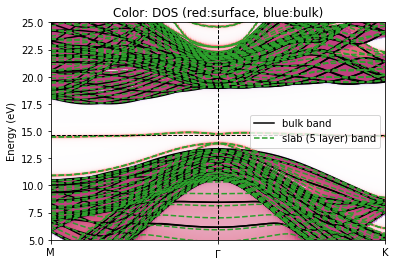

In [15]:
# Plot bulk band structure for different kz values
label = 'bulk band'
for ikz, kz in enumerate(kz_list):
    for ib in range(tbbulk.nw):
        plt.plot(kplot, energy_bulk_all[ikz,ib,:], '-', c='k', label=label)
        label = None
label = 'slab (5 layer) band'
for ib in range(tbslab.nw):
    plt.plot(kplot, energy_slab_all[ib,:], '--', c='C2', label=label)
    label = None
        
# Plot bulk and surface DOS
filenames = ['dos_bulk.out', 'dos_surf00.out']
for filename in filenames:
    # Open .out file (which is a binary file)
    with open(filename, 'r') as f:
        data = np.fromfile(f, dtype=np.float64).reshape((nk, ne))
    # Set colormap for plotting DOS (bulk: blue, surface: red)
    cmap_ = cmap_white_red
    if filename == 'dos_bulk.out':
        cmap_ = cmap_white_blue
    # Plot DOS
    plt.imshow(np.transpose(data), extent=extent, origin='lower', cmap=cmap_,
               alpha = 0.5, aspect='auto', vmin=0, vmax=0.5)

# Formatting figure
plt.xticks(special_k, special_k_label)
plt.xlim([special_k[0], special_k[-1]])
for x in special_k[1:-1]:
    plt.axvline(x=x, c='k', ls='--', lw=1)
plt.axhline(y=EFermi - bulk_shift, c='k', ls='--', lw=1)
plt.ylabel('Energy (eV)')
plt.legend()
plt.title('Color: DOS (red:surface, blue:bulk)')
plt.show()

When the Wannier functions are used as the tight-binding basis functions, one should always care about the similarity of the bulk and slab basis functions to be identified. An improper construction of Wannier functions or semiinfinite surface models may lead to "seamed stitching", in which an unphysical impurity is generated at the interface where the surface and the bulk are matched. For example, suppose that the WFs of the bulk have different order to the Wannier functions of the slab. (e.g., bulk WFs are px, py, pz orbitals in the order of their indicecs, while slab WFs are pz, px, py orbitals.) If one naively identifies the bulk and slab WFs with the same indices, strange unphysical results can be found.

To avoid this problem, we use the "disentanglement-only WFs", where the WFs are construced by directly projecting the atomic-orbital-like initial guesses to some optimized subspace of Kohn-Sham states. The optimized subspace is obtained by the disentanglement procedure of Souza, Marzari, and Vanderbilt.
* Note the `num_iter = 0` keyword in the \*.win files. This keyword disables the maximal localization step.
* The initial guesses in this example are the sp3 atomic orbitals: see the block between `begin projections` and `end projections` in the \*.win files.

(As an aside, we note that one can achieve "seamless stitching" with MLWFs by performing post-processing corrections: see Jae-Mo Lihm and Cheol-Hwan Park, Phys. Rev. B 99, 125117 (2019))

Also, the in-plane components of the centers of the corresponding bulk and slab WFs must be similar.
The indices of the slab WFs which are identified with the bulk WFs are set by the input keyword `ind_1 = 61-84` in the semiinf.in file.
The centers of the slab WFs with these indices can be found in the `slab/diam.slab.wout` file.
By comparing this information with those in the `bulk/diam.bulk.wout` file, check that the in-plance coordinates of the center of these WFs are similar (index by index) with those of the bulk WFs.

Finally, we directly check the hopping parameters directly to check whether the bulk and slab Wannier functions (WFs) can be "seamlessly stitched".
Here, we plot the intra-cell tight-binding elements for the bulk and the slab.
We find that the tight-binding elements are almost identical.

You can also test the intra-cell components by yourself.

Max error = 8.19 meV


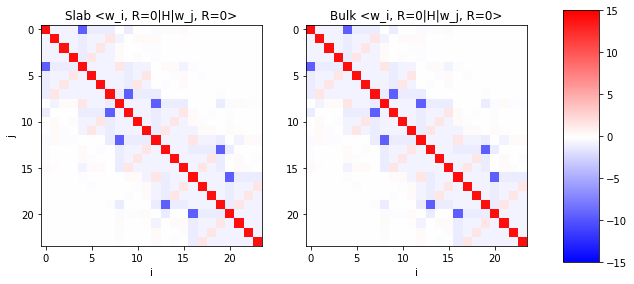

In [20]:
# Set indices
ind_1 = slice(60, 84) # Python uses 0-based index, while semiinf.x uses 1-based index. So, ind_1(python) = 60, ..., 83
irs_000 = tbslab.get_ir_ind([0, 0, 0]) # ir index with R = (0, 0, 0): onsite (intra-cell) component
irb_000 = tbbulk.get_ir_ind([0, 0, 0]) # ir index with R = (0, 0, 0): onsite (intra-cell) component

# Plot Hamiltonian matrix elements
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
im0 = axes[0].imshow(tbslab.hr[irs_000,ind_1,ind_1].real, vmin=-15, vmax=15, origin='upper', cmap='bwr')
im1 = axes[1].imshow(tbbulk.hr[irb_000,:,:].real, vmin=-15, vmax=15, origin='upper', cmap='bwr')
# Format plot
axes[0].set_title('Slab <w_i, R=0|H|w_j, R=0>')
axes[1].set_title('Bulk <w_i, R=0|H|w_j, R=0>')
axes[0].set_xlabel('i')
axes[1].set_xlabel('i')
axes[0].set_ylabel('j')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im1, cax=cbar_ax)
plt.show()

# Maximum error in the matrix elements
print(f"Max error = {np.amax(abs(tbslab.hr[irs_000,ind_1,ind_1] - tbbulk.hr[irb_000,:,:]))*1E3:.2f} meV")